In [1]:
# Libraries

import gsk_data_cleaning
import gsk_feature_eng
import gsk_modeling
import gsk_error_analysis
import gsk_eda

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pycountry
from rchitect import *

from dateutil.relativedelta import relativedelta

In [2]:
np.random.seed(123)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

pd.set_option('display.float_format', lambda x: "%3.f" % x)

----

In [3]:
sb_data = pd.read_csv("../data/tenant_data/export17_sku_banner.csv", dtype="str")

sb_data["Actual"] = np.where((sb_data["Actual"].isnull()) & (sb_data["Sales Domain.[Channel]"]=="Malaysia")
                             , sb_data["Sell Out Actual"]
                             , sb_data["Actual"])

sb_data.drop(["Version.[Version Name]", "Sell Out Actual"], axis=1, inplace=True)

sb_data.rename(columns = {"Time.[Planning Month]": "month"
                          , "Sales Domain.[Channel]": "country"
                          , "Sales Domain.[Ship To]": "customer"
                          , "Item.[Transition Item]": "sku"
                          , "Actual": "actuals"}, inplace=True)

sb_data["month"] = pd.to_datetime(sb_data["month"], format='%b-%y')
sb_data["actuals"] = sb_data["actuals"].astype("float64")

sb_data = sb_data[["sku", "customer", "month", "country", "actuals"]]
sb_data

,sku,customer,month,country,actuals
0,60000000109576,8300001929,2016-01-01,Australia,4248
1,60000000109576,8300001937,2016-01-01,Australia,34632
2,60000000109576,8300001938,2016-01-01,Australia,16560
3,60000000109576,8300001929,2016-02-01,Australia,4176
4,60000000109576,8300001937,2016-02-01,Australia,39096
...,...,...,...,...,...
32640,60000000106931,8300000375,2016-08-01,Germany,570
32641,60000000113135,8300000394,2018-09-01,Germany,810000
32642,60000000113135,8300000394,2018-10-01,Germany,348000
32643,60000000113135,8300000394,2018-11-01,Germany,739980


In [4]:
sb_data.nunique()

sku          311
customer     107
month         36
country        4
actuals     5287
dtype: int64

In [5]:
sb_data.isnull().sum()

sku         0
customer    0
month       0
country     0
actuals     0
dtype: int64

### Upsampling

In [6]:
print(sb_data.shape)
sb_data_ups = gsk_data_cleaning.perform_upsampling(sb_data, grouped_on=["sku", "customer"], dependent_col="actuals", date_col="month")

sb_data_ups.shape

(32645, 5)


(62798, 9)

In [7]:
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Poland", "PL", "abc")
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Germany", "DE", sb_data_ups["country_code"])
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Australia", "AU", sb_data_ups["country_code"])
sb_data_ups["country_code"]=np.where(sb_data_ups["country"]=="Malaysia", "MY", sb_data_ups["country_code"])

In [8]:
sb_data_ups.sample(10)

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code
6730,515773,8300000338,186,2018-11-01,Germany,0,1,2016-05-01,2018-10-01,DE
14313,530643,8300000585,397,2017-10-01,Germany,0,1,2016-07-01,2018-11-01,DE
19869,532409,8300000162,551,2018-10-01,Germany,800,0,2018-01-01,2018-10-01,DE
62485,60000000109477,8300000336,1735,2018-02-01,Germany,0,1,2017-06-01,2017-06-01,DE
60115,60000000108178,8300000285,1669,2018-08-01,Germany,0,1,2017-06-01,2017-06-01,DE
83698,89246,8300000338,2324,2018-11-01,Germany,0,1,2016-03-01,2016-03-01,DE
29789,60000000042868,8300002845,827,2017-06-01,Germany,0,1,2016-08-01,2016-08-01,DE
53847,60000000107016,8300000265,1495,2018-04-01,Germany,0,1,2018-02-01,2018-11-01,DE
7349,515773,8300002370,204,2016-06-01,Germany,580,0,2016-04-01,2018-12-01,DE
18055,531037,8300000397,501,2017-08-01,Germany,20,0,2016-07-01,2018-11-01,DE


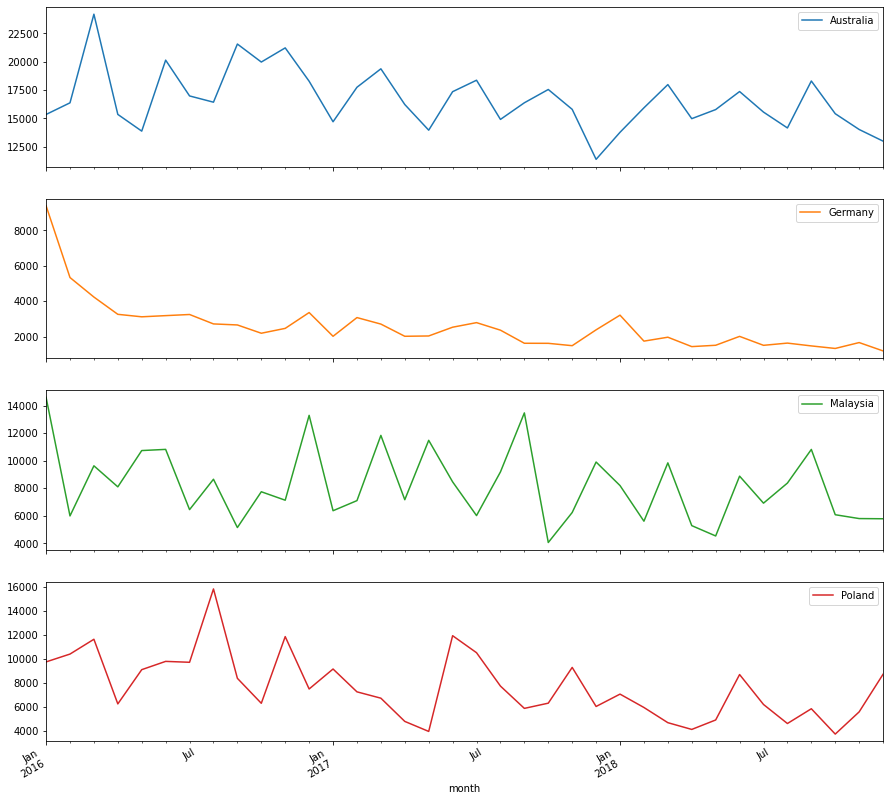

In [9]:
sb_data_ups[["month", "country", "actuals"]].pivot_table(index="month", columns="country", values="actuals").plot(subplots=True, sharex= True, figsize=(15, 15))
plt.show()

### Moving Averages

In [10]:
sb_data_ups = gsk_feature_eng.create_lag_variables(sb_data_ups, date_column="month"
                                                   , grouped_on = "sequence"
                                                   , shifting_var = "actuals"
                                                   , lag_vars_range = [3, 4, 5, 6, 7])

sb_data_ups = gsk_feature_eng.create_moving_avg(sb_data_ups, ma_vars = [1,2,3,4,5])
sb_data_ups.drop(["lag_3", "lag_4", "lag_5", "lag_6", "lag_7"], axis=1, inplace=True)
sb_data_ups

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
9,045019,8300002617,0,2016-10-01,Poland,24,0,2016-10-01,2017-10-01,PL,0,0,0,0,0
10,045019,8300002617,0,2016-11-01,Poland,0,1,2016-10-01,2017-10-01,PL,0,0,0,0,0
11,045019,8300002617,0,2016-12-01,Poland,30,0,2016-10-01,2017-10-01,PL,0,0,0,0,0
12,045019,8300002617,0,2017-01-01,Poland,0,1,2016-10-01,2017-10-01,PL,24,12,8,6,5
13,045019,8300002617,0,2017-02-01,Poland,0,1,2016-10-01,2017-10-01,PL,0,12,8,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87079,9840,8300000394,2418,2018-08-01,Germany,0,1,2016-04-01,2016-04-01,DE,0,0,0,0,0
87080,9840,8300000394,2418,2018-09-01,Germany,0,1,2016-04-01,2016-04-01,DE,0,0,0,0,0
87081,9840,8300000394,2418,2018-10-01,Germany,0,1,2016-04-01,2016-04-01,DE,0,0,0,0,0
87082,9840,8300000394,2418,2018-11-01,Germany,0,1,2016-04-01,2016-04-01,DE,0,0,0,0,0


## Function related to Univariate Modeling

In [11]:
def start_univariate_modeling(dataset, forecast_month, date_col, lag_of=2, grouped_on="sequence", dependent_var="actual"):
    
    from functools import reduce

    results=pd.DataFrame()

    print("Running Arima...")
    arima_results = gsk_modeling.perform_autoarima(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                   , grouped_on=grouped_on, dependent_var=dependent_var)
    print("Running ETS...")
    ets_results = gsk_modeling.perform_ets(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                           , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
    print("Running Seasonal Naive...")
    sktime_naive_results = gsk_modeling.perform_sktime_naive(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
                                                             , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
#     print("Running Reduction...")
#     red_results = gsk_modeling.perform_sktime_reduction(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
#                                                         , grouped_on=grouped_on, dependent_var=dependent_var).drop([dependent_var], axis=1)
#     print("Running Prophet...")
#     prophet_results = gsk_modeling.create_prophet_forecast(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, date_col=date_col
#                                                            , grouped_on=grouped_on, dependent_var=dependent_var)
    
    dataframes = [arima_results
                  , ets_results
                  , sktime_naive_results
                  , red_results
                  , prophet_results]
    
    results = reduce(lambda left, right: pd.merge(left, right, on = [grouped_on, date_col], how='inner'), dataframes)
    
    return results

-----
# Forecasting for October 2018

> - Training Month : Till April 2018    
> - Validation Month: July 2018    
> - Prediction Month: October 2018

In [123]:
sb_data_ups[sb_data_ups["sequence"]==550]

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
19824,532409,8300000160,550,2018-01-01,Germany,6140,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19825,532409,8300000160,550,2018-02-01,Germany,10056,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19826,532409,8300000160,550,2018-03-01,Germany,9905,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19827,532409,8300000160,550,2018-04-01,Germany,9450,0,2018-01-01,2018-12-01,DE,6140,3070,2047,1535,1228
19828,532409,8300000160,550,2018-05-01,Germany,14160,0,2018-01-01,2018-12-01,DE,10056,8098,5399,4049,3239
19829,532409,8300000160,550,2018-06-01,Germany,55555,0,2018-01-01,2018-12-01,DE,9905,9980,8700,6525,5220
19830,532409,8300000160,550,2018-07-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110
19831,532409,8300000160,550,2018-08-01,Germany,64740,0,2018-01-01,2018-12-01,DE,14160,11805,11172,10893,9942
19832,532409,8300000160,550,2018-09-01,Germany,5280,0,2018-01-01,2018-12-01,DE,55555,34858,26388,22267,19825
19833,532409,8300000160,550,2018-10-01,Germany,0,1,2018-01-01,2018-12-01,DE,15606,35580,28440,23693,20935


In [111]:
sb_data_ups[sb_data_ups["sku"]=="60000000109204"]

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
61791,60000000109204,8300000160,1716,2017-04-01,Germany,22,0,2017-04-01,2017-06-01,DE,0,0,0,0,0
61792,60000000109204,8300000160,1716,2017-05-01,Germany,2,0,2017-04-01,2017-06-01,DE,0,0,0,0,0
61793,60000000109204,8300000160,1716,2017-06-01,Germany,3,0,2017-04-01,2017-06-01,DE,0,0,0,0,0
61794,60000000109204,8300000160,1716,2017-07-01,Germany,0,1,2017-04-01,2017-06-01,DE,22,11,7,6,4
61795,60000000109204,8300000160,1716,2017-08-01,Germany,0,1,2017-04-01,2017-06-01,DE,2,12,8,6,5
61796,60000000109204,8300000160,1716,2017-09-01,Germany,0,1,2017-04-01,2017-06-01,DE,3,2,9,7,5
61797,60000000109204,8300000160,1716,2017-10-01,Germany,0,1,2017-04-01,2017-06-01,DE,0,2,2,7,5
61798,60000000109204,8300000160,1716,2017-11-01,Germany,0,1,2017-04-01,2017-06-01,DE,0,0,1,1,5
61799,60000000109204,8300000160,1716,2017-12-01,Germany,0,1,2017-04-01,2017-06-01,DE,0,0,0,1,1
61800,60000000109204,8300000160,1716,2018-01-01,Germany,0,1,2017-04-01,2017-06-01,DE,0,0,0,0,1


In [12]:
training_validation = sb_data_ups[sb_data_ups["month"]<="2018-07-01"]
training_prediction = sb_data_ups[sb_data_ups["month"]<="2018-10-01"]

training_validation.shape, training_prediction.shape, training_prediction.sequence.nunique(), training_validation.sequence.nunique()

((50882, 15), (57970, 15), 2388, 2310)

In [13]:
training_validation.sample(2)

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
1525,30P794,8300001918,42,2017-02-01,Australia,17856,0,2016-01-01,2018-12-01,AU,43776,40320,41472,41760,40090
24444,60000000008433,8300000333,679,2016-01-01,Germany,36,0,2016-01-01,2017-07-01,DE,0,0,0,0,0


### Adding `time-series` features like

1. Maturity
2. last 12 months moving average
3. mean
4. median
5. length of series
6. standard deviation
7. Coefficient of Variation

> maturity limit: April 2018

In [14]:
print(training_validation.sequence.nunique())
training_validation = gsk_feature_eng.series_info(dataset = training_validation
                                                  , month_var = "month"
                                                  , grouped_on = "sequence"
                                                  , dependent_var = "actuals"
                                                  , forecast_month = "2018-07-01"
                                                  , lag_of=2)

training_validation.sequence.nunique()

2310


2310

In [15]:
training_validation = gsk_feature_eng.check_maturity(dataset = training_validation
                                                     , date_column = "month"
                                                     , grouped_on = "sequence"
                                                     , dependent_var = "actuals"
                                                     , forecast_month = "2018-07-01")

training_validation.groupby(["sequence"]).agg({"mature":pd.unique}).reset_index().mature.value_counts()

1    1728
0     582
Name: mature, dtype: int64

In [16]:
training_validation.sample(1)

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,cutoff_date,los,series_mean,series_median,series_stdev,series_cov,ma_12,mature
25008,60000000101121,8300000395,989,2017-03-01,Germany,12,0,2016-01-01,2018-01-01,DE,12,18,24,21,17,2018-04-01,17,25,24,13,51,14,1


#### Step-1:
> Filling `immature` time-series with `Forecast=0`

In [17]:
training_validation["Forecast"]=0

In [18]:
# tv_subset[(tv_subset["los"]==1) & (tv_subset["mature"]==1)].sequence.unique()

In [19]:
tk = training_validation.groupby(["sequence"]).agg({"los": pd.unique, "mature": pd.unique, "month_min": pd.unique}).reset_index()

In [20]:
tk[(tk["los"]==1) & (tk["mature"]==1)].month_min.value_counts()

2018-04-01    77
2017-08-01    12
2017-06-01    12
2017-07-01    11
2017-09-01    11
2018-01-01     9
2017-10-01     8
2018-03-01     7
2018-02-01     7
2017-12-01     6
2017-11-01     5
2017-05-01     4
Name: month_min, dtype: int64

In [21]:
tk[(tk["month_min"]=="2017-11-01") & (tk["los"]==1) & (tk["mature"]==1)]

,sequence,los,mature,month_min
288,293,1,1,2017-11-01
1381,1396,1,1,2017-11-01
1635,1661,1,1,2017-11-01
1642,1668,1,1,2017-11-01
1750,1791,1,1,2017-11-01


In [22]:
tk[(tk["month_min"]=="2018-04-01") & (tk["los"]==1) & (tk["mature"]==1)].sample(5)

,sequence,los,mature,month_min
1870,1947,1,1,2018-04-01
1756,1797,1,1,2018-04-01
1815,1875,1,1,2018-04-01
1814,1874,1,1,2018-04-01
1817,1877,1,1,2018-04-01


In [121]:
training_validation[training_validation["sequence"]==1947]

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,cutoff_date,los,series_mean,series_median,series_stdev,series_cov,ma_12,mature,Forecast
40262,60000000112876,8300001910,1947,2018-04-01,Germany,10452,0,2018-04-01,2018-08-01,DE,0,0,0,0,0,2018-04-01,1,10452,10452,0,0,871,1,0
40263,60000000112876,8300001910,1947,2018-05-01,Germany,14736,0,2018-04-01,2018-08-01,DE,0,0,0,0,0,2018-04-01,1,10452,10452,0,0,871,1,0
40264,60000000112876,8300001910,1947,2018-06-01,Germany,0,1,2018-04-01,2018-08-01,DE,0,0,0,0,0,2018-04-01,1,10452,10452,0,0,871,1,0
40265,60000000112876,8300001910,1947,2018-07-01,Germany,0,1,2018-04-01,2018-08-01,DE,10452,5226,3484,2613,2090,2018-04-01,1,10452,10452,0,0,871,1,2090


#### Step-2
_so, after analysing such cases, one thing is sure, it is better to fill them with `moving averages`, if it is zero, it will be the best invariant approximation_

> If last 5 months are zero from the _current-month_, it will be zero, otherwise `moving average-5`

In [24]:
training_validation["Forecast"] = np.where((training_validation["los"].isin([1,2,3])) & (training_validation["mature"]==1)
                                           , training_validation["ma_5"]
                                           , training_validation["Forecast"])

In [25]:
tk[(tk["los"]==4) & (tk["mature"]==1)].month_min.value_counts()

2018-01-01    22
2017-09-01     9
2017-04-01     7
2016-06-01     7
2017-11-01     6
2016-05-01     6
2017-07-01     5
2016-10-01     4
2016-07-01     4
2017-12-01     4
2016-01-01     3
2017-10-01     2
2016-02-01     2
2016-11-01     2
2017-05-01     2
2017-02-01     2
2016-12-01     2
2017-08-01     2
2017-01-01     1
2017-03-01     1
Name: month_min, dtype: int64

In [26]:
tk[(tk["month_min"]=="2018-01-01") & (tk["los"]==4) & (tk["mature"]==1)]

,sequence,los,mature,month_min
541,550,4,1,2018-01-01
542,551,4,1,2018-01-01
543,552,4,1,2018-01-01
544,553,4,1,2018-01-01
545,554,4,1,2018-01-01
549,558,4,1,2018-01-01
551,560,4,1,2018-01-01
552,561,4,1,2018-01-01
555,564,4,1,2018-01-01
559,568,4,1,2018-01-01


In [94]:
training_validation[training_validation["los"]==28].sequence.unique()

array([  16,   17,   19,   20,   22,   23,   25,   26,   28,   29,   31,
         32,   40,   41,   42,   44,   45,  243,  373,  638,  642,  657,
        658,  693,  810,  811,  813,  818,  870,  875,  885,  886,  888,
        890,  933,  936,  937,  946,  947, 1035, 1038, 1110, 1121, 1125,
       1272, 1275, 1280, 1285, 1287, 1288, 1290, 1291, 1293, 1295, 1307,
       1309, 1739, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2084, 2093, 2094, 2095, 2100, 2101, 2112, 2113, 2115, 2116,
       2118, 2119, 2121, 2122, 2123, 2129, 2131, 2132, 2134, 2135, 2136,
       2138, 2141, 2142, 2144, 2145, 2146, 2148, 2149, 2150, 2151, 2152,
       2156, 2157, 2158, 2160, 2162, 2169, 2236, 2237, 2238, 2239, 2241,
       2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2256, 2271, 2274,
       2282, 2285, 2373, 2375, 2376, 2382, 2386, 2388, 2394, 2396, 2398,
       2401, 2403, 2404], dtype=int64)

In [103]:
seq_16 = training_validation[training_validation["sequence"]==16].drop(["Forecast"], axis=1)
# single_run_arima(seq_550, 2, "2018-07-01", 1, "month", "actuals")

In [105]:
# gsk_modeling.single_run_arima(sub_data = seq_16, lag_of = 2, forecast_month = "2018-07-01", forecast_period=12, month_var="month", dependent_var="actuals")

In [110]:
training_prediction[training_prediction["sequence"]==550]

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5
19824,532409,8300000160,550,2018-01-01,Germany,6140,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19825,532409,8300000160,550,2018-02-01,Germany,10056,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19826,532409,8300000160,550,2018-03-01,Germany,9905,0,2018-01-01,2018-12-01,DE,0,0,0,0,0
19827,532409,8300000160,550,2018-04-01,Germany,9450,0,2018-01-01,2018-12-01,DE,6140,3070,2047,1535,1228
19828,532409,8300000160,550,2018-05-01,Germany,14160,0,2018-01-01,2018-12-01,DE,10056,8098,5399,4049,3239
19829,532409,8300000160,550,2018-06-01,Germany,55555,0,2018-01-01,2018-12-01,DE,9905,9980,8700,6525,5220
19830,532409,8300000160,550,2018-07-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110
19831,532409,8300000160,550,2018-08-01,Germany,64740,0,2018-01-01,2018-12-01,DE,14160,11805,11172,10893,9942
19832,532409,8300000160,550,2018-09-01,Germany,5280,0,2018-01-01,2018-12-01,DE,55555,34858,26388,22267,19825
19833,532409,8300000160,550,2018-10-01,Germany,0,1,2018-01-01,2018-12-01,DE,15606,35580,28440,23693,20935


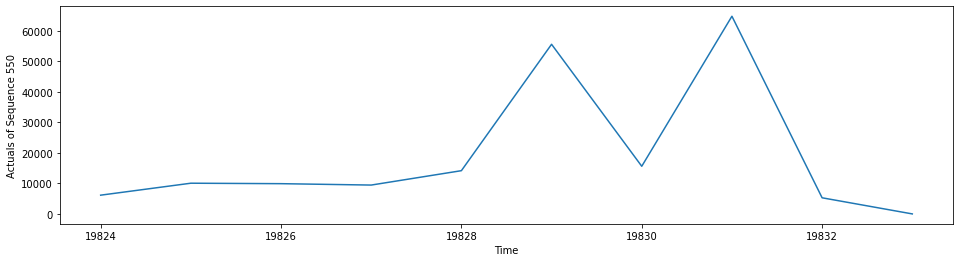

In [122]:
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.model_selection import temporal_train_test_split

y = training_prediction[training_prediction["sequence"]==550]["actuals"]
y_train, y_test = temporal_train_test_split(y, test_size=3)

fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Actuals of Sequence 550");



# plot_ys(y_train, y_test, labels=["y_train", "y_test"])
# print(y_train.shape[0], y_test.shape[0])

In [109]:
seq_550 = training_validation[training_validation["sequence"]==550].drop(["Forecast"], axis=1)
gsk_modeling.single_run_arima(sub_data = seq_550, lag_of = 2, forecast_month = "2018-10-01", forecast_period=12, month_var="month", dependent_var="actuals")

,sku,customer,sequence,month,country,actuals,upsample,month_min,month_max,country_code,naive,ma_2,ma_3,ma_4,ma_5,cutoff_date,los,series_mean,series_median,series_stdev,series_cov,ma_12,mature,Forecast
0,532409,8300000160,550,2018-01-01,Germany,6140,0,2018-01-01,2018-12-01,DE,0,0,0,0,0,2018-04-01,4,8888,9677,1602,18,2963,1,nan
1,532409,8300000160,550,2018-02-01,Germany,10056,0,2018-01-01,2018-12-01,DE,0,0,0,0,0,2018-04-01,4,8888,9677,1602,18,2963,1,nan
2,532409,8300000160,550,2018-03-01,Germany,9905,0,2018-01-01,2018-12-01,DE,0,0,0,0,0,2018-04-01,4,8888,9677,1602,18,2963,1,nan
3,532409,8300000160,550,2018-04-01,Germany,9450,0,2018-01-01,2018-12-01,DE,6140,3070,2047,1535,1228,2018-04-01,4,8888,9677,1602,18,2963,1,nan
4,532409,8300000160,550,2018-05-01,Germany,14160,0,2018-01-01,2018-12-01,DE,10056,8098,5399,4049,3239,2018-04-01,4,8888,9677,1602,18,2963,1,nan
5,532409,8300000160,550,2018-06-01,Germany,55555,0,2018-01-01,2018-12-01,DE,9905,9980,8700,6525,5220,2018-04-01,4,8888,9677,1602,18,2963,1,nan
6,532409,8300000160,550,2018-07-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110,2018-04-01,4,8888,9677,1602,18,2963,1,nan
7,532409,8300000160,550,2018-08-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110,2018-04-01,4,8888,9677,1602,18,2963,1,17267
8,532409,8300000160,550,2018-09-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110,2018-04-01,4,8888,9677,1602,18,2963,1,17267
9,532409,8300000160,550,2018-10-01,Germany,15606,0,2018-01-01,2018-12-01,DE,9450,9677,9804,8888,7110,2018-04-01,4,8888,9677,1602,18,2963,1,17267


In [ ]:
# gsk_modeling.single_run_arima(sub_data = seq_16, lag_of = 2, forecast_month = "2018-07-01", forecast_period=12, month_var="month", dependent_var="actuals")

In [29]:
sub_data=seq_550
lag_of=2
forecast_month="2018-07-01"
forecast_period=12
month_var="month"
dependent_var="actuals"

In [30]:
# from sktime.forecasting.arima import AutoARIMA
# import warnings
# warnings.filterwarnings("ignore")
import pmdarima as pm

In [87]:
cutoff_date = pd.to_datetime(forecast_month)-pd.offsets.MonthBegin(lag_of)

train=sub_data[sub_data[month_var]<cutoff_date].set_index(month_var)[[dependent_var]]

df = pd.DataFrame(columns = [month_var, "Forecast"])

In [88]:
train

,actuals
month,
2018-01-01,6140
2018-02-01,10056
2018-03-01,9905
2018-04-01,9450
2018-05-01,14160
2018-06-01,55555
2018-07-01,15606


In [34]:
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1
                     , max_p=5, max_q=5, max_P=5, max_Q=5
                     , seasonal=True, stepwise=True
                     , suppress_warnings=True, D=10, max_D=10
                     , error_action="ignore")

In [35]:
modl

ARIMA(order=(1, 0, 1), suppress_warnings=True)

In [38]:
train

,actuals
month,
2018-01-01,6140
2018-02-01,10056
2018-03-01,9905
2018-04-01,9450


In [39]:
# modl.predict(n_periods = 3)

In [41]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.arima import AutoARIMA

In [71]:
y_train=sub_data[sub_data[month_var]<cutoff_date][dependent_var].reset_index(drop=True)
y_test=sub_data[sub_data[month_var]>=cutoff_date][dependent_var].reset_index(drop=True)
y_train.shape, y_test.shape

((4,), (3,))

In [72]:
fh = np.arange(len(y_test)) + 1
fh

array([1, 2, 3])

In [78]:
y_train

0    6140
1   10056
2    9905
3    9450
Name: actuals, dtype: float64

In [81]:
y_train = pd.Series([6140, 10056, 9905, 9450])

In [82]:
forecaster = AutoARIMA(suppress_warnings=True)#, sp=12)
forecaster.fit(y_train)

AutoARIMA(suppress_warnings=True)

In [84]:
y_pred = forecaster.predict([1])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:

smape_loss(y_test, y_pred)

In [36]:


preds = modl.predict(n_periods = 3)#forecast_period, return_conf_int=False)
preds = np.round(preds)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [102]:
def single_run_arima(sub_data, lag_of, forecast_month, forecast_period, month_var, dependent_var):
    # Library import
    import pmdarima as pm
    import warnings
    warnings.filterwarnings("ignore")
    
    # Decide on cut-off based on lag and forecast month
    cutoff_date = pd.to_datetime(forecast_month)-pd.offsets.MonthBegin(lag_of)
    
    train=sub_data[sub_data[month_var]<cutoff_date].set_index(month_var)[[dependent_var]]
    
    df = pd.DataFrame(columns = [month_var, "Forecast"])
    
    modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1
                         , max_p=5, max_q=5, max_P=5, max_Q=5
                         , seasonal=True, stepwise=True
                         , suppress_warnings=True, D=10, max_D=10
                         , error_action="ignore")
    
    preds = modl.predict(n_periods = forecast_period, return_conf_int=False)
    preds = np.round(preds)
    
    dates = pd.date_range(start = cutoff_date, periods = forecast_period, freq="MS")
    
    df[month_var] = dates
    df["Forecast"] = preds
    
    df = pd.merge(left = sub_data, right = df, on = month_var, how="outer")
    cols = df.columns
    df.loc[:, cols] = df.loc[:, cols].ffill()
    
    df["Forecast"] = np.where(df["Forecast"]<0,0,df["Forecast"])
    
    return df

In [26]:
mature_sku_training = training_validation[training_validation["mature"]==1]
mature_sku_training.shape, mature_sku_training.sequence.nunique(), mature_sku_training.sku.nunique(), mature_sku_training.customer.nunique()

((37623, 17), 1728, 235, 99)

### Modeling on training data

In [29]:
july_univ_results = start_univariate_modeling(dataset = training_validation
                                              , forecast_month = "2018-07-01"
                                              , date_col = "month"
                                              , lag_of=2
                                              , grouped_on="sequence"
                                              , dependent_var="actuals")
july_univ_results.shape

  0%|                                                                                                                                                                                    | 0/2310 [00:00<?, ?it/s]

Running Arima...


  3%|█████▍                                                                                                                                                                     | 73/2310 [00:12<06:37,  5.62it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



_segmentation data prepared_

---

### Preparing modeling data
----

#### RFM variables for `customers`

In [17]:
# australia.series_length.value_counts().head()
october = gsk_feature_eng.create_rfm_variables(dataset, lag_of=2, forecast_month="2017-10-01", dependent_var="actual", show_distributions = False, show_rfm_clusters = False)
november = gsk_feature_eng.create_rfm_variables(dataset, lag_of=2, forecast_month="2017-11-01", dependent_var="actual", show_distributions = False, show_rfm_clusters = False)
december = gsk_feature_eng.create_rfm_variables(dataset, lag_of=2, forecast_month="2017-12-01", dependent_var="actual", show_distributions = False, show_rfm_clusters = False)

october.shape, november.shape, december.shape

snapshot_date taken is 2017-08-01 00:00:00
snapshot_date taken is 2017-09-01 00:00:00
snapshot_date taken is 2017-10-01 00:00:00


((28074, 40), (30034, 40), (32039, 40))

### Adding segmentation related variables

In [18]:
# australia[australia["series_length"]==0]
october = gsk_feature_eng.prepare_modeling_data(october, segmentation_july[["sku", "banner", "volume", "forecast_rule"]], forecast_month="2017-10-01")
november = gsk_feature_eng.prepare_modeling_data(november, segmentation_august[["sku", "banner", "volume", "forecast_rule"]], forecast_month="2017-11-01")
december = gsk_feature_eng.prepare_modeling_data(december, segmentation_september[["sku", "banner", "volume", "forecast_rule"]], forecast_month="2017-12-01")

october.shape, november.shape, december.shape

((28074, 42), (30034, 42), (32039, 42))

In [19]:
# australia[australia["sequence"]==86]
october.sku.nunique()

240

_data preparation is completed here.._

-----

# Modeling

In [26]:
def start_univariate_modeling(dataset, forecast_month, lag_of=2, grouped_on="sequence", dependent_var="actual"):
    
    from functools import reduce

    results=pd.DataFrame()
    
    print("Running Croston...")
    croston_results = gsk_modeling.create_croston_forecast(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var)
#     prophet_results = gsk_modeling.create_prophet_forecast(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var)
    print("Running Arima...")
    arima_results = gsk_modeling.perform_autoarima(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var)
    print("Running ETS...")
    ets_results = gsk_modeling.perform_ets(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var).drop(["actual"], axis=1)
    
#     af_results = gsk_modeling.perform_af(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var).drop(["actual"], axis=1)
    print("Running Seasonal Naive...")
    sktime_naive_results = gsk_modeling.perform_sktime_naive(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var).drop(["actual"], axis=1)
    print("Running Reduction...")
    red_results = gsk_modeling.perform_sktime_reduction(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var).drop(["actual"], axis=1)
    print("Running Univariate Ensemble...")
    ensemble_results = gsk_modeling.perform_detrend_ensemble(dataset=dataset, lag_of=lag_of, forecast_month=forecast_month, grouped_on=grouped_on, dependent_var=dependent_var, seasonality_period=4).drop(["actual"], axis=1)
    
    dataframes = [croston_results
#                   , prophet_results
                  , arima_results, ets_results
#                   , af_results
                  , sktime_naive_results, red_results, ensemble_results]
    results = reduce(lambda left, right: pd.merge(left, right, on = ["sequence", "month"], how='inner'), dataframes)
    
    return results

In [27]:
oct17_univ = start_univariate_modeling(dataset = october, forecast_month = "2017-10-01")

oct17_univ.sample(3)

  0%|▋                                                                                                                                                                           | 7/1895 [00:00<00:27, 69.44it/s]

Running Croston...


  0%|                                                                                                                                                                            | 1/2012 [00:00<04:00,  8.35it/s]

Running Arima...


  0%|▌                                                                                                                                                                           | 6/2012 [00:00<00:40, 49.42it/s]

Running ETS...


  1%|██▍                                                                                                                                                                       | 29/2012 [00:00<00:07, 282.31it/s]

Running Seasonal Naive...


  0%|                                                                                                                                                                                    | 0/2012 [00:00<?, ?it/s]

Running Reduction...


  0%|                                                                                                                                                                                    | 0/2012 [00:00<?, ?it/s]

Running Univariate Ensemble...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2012/2012 [18:50<00:00,  1.78it/s]


,sequence,month,croston_status,croston_forecast,actual,arima_forecast,arima_status,ets_forecast,ets_status,sn_forecast,sn_status,red_forecast,red_status,ensemble_forecast,ensemble_status
318,341,2017-10-01,0,162.000,0.000,132.285,0.000,160.819,0.000,0.000,0,0.000,0,0.000,0
16,16,2017-10-01,0,109.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,0
410,434,2017-10-01,0,436.000,0.000,298.405,0.000,373.655,0.000,350.000,0,0.000,0,0.000,0


In [28]:
print(oct17_univ.shape)
oct17_univ = pd.merge(left=october[october["month"]=="2017-10-01"][["sequence", "upsample", "month", "forecast_rule", "country", "ma_3", "ma_4", "ma_5"]]
                       , right=oct17_univ
                      , on = ["sequence", "month"]
                       , how="inner")
oct17_univ.sequence.nunique()

(1895, 15)


1895

In [30]:
gsk_error_analysis.show_results(oct17_univ, list_of_forecast=["croston_forecast"
                                                              , "arima_forecast", "ets_forecast"
                                                              , "sn_forecast", "red_forecast", "ensemble_forecast"
                                                              , "ma_3", "ma_4", "ma_5"])

Algorithm,arima_forecast,croston_forecast,ensemble_forecast,ets_forecast,ma_3,ma_4,ma_5,red_forecast,sn_forecast
forecast_rule,,,,,,,,,
2.000,59.561,49.585,31.417,44.411,53.336,58.048,54.619,30.101,18.910
3.000,68.352,69.629,58.396,69.023,73.436,70.320,72.704,63.738,61.089
4.000,32.332,4.310,-9.793,-20.702,19.233,23.432,32.318,-18.471,3.101
6.000,24.299,54.668,1.792,16.714,50.137,38.098,31.305,1.936,2.191
7.000,39.596,55.869,41.614,10.060,59.547,62.502,61.707,42.315,48.443
8.000,1.602,39.474,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [31]:
def start_multivariate_modeling(dataset, forecast_month, lag_of=2, grouped_on="sequence", dependent_var="actual"):
    mlm_results = gsk_modeling.perform_mixedLM(dataset = dataset, forecast_month=forecast_month, lag_of=lag_of, grouped_on=grouped_on, dependent_var=dependent_var)
    xgb_results = gsk_modeling.perform_xgb(dataset = dataset, forecast_month=forecast_month, lag_of=lag_of, grouped_on=grouped_on, dependent_var=dependent_var)
    
    results = pd.merge(left = mlm_results, right = xgb_results, on=["sequence", "month", "actual", "country", "forecast_rule"], how="inner")
    
    return results

In [33]:
oct_mv_results = start_multivariate_modeling(dataset = october, forecast_month="2017-10-01")
oct_mv_results.sample()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


,sequence,country,forecast_rule,month,actual,mlm_preds,mlm_status,xgb_predictions,xgb_status
458,807,Germany,7.000,2017-10-01,0.000,0.000,0,1195.235,0


In [35]:
gsk_error_analysis.show_results(oct_mv_results, list_of_forecast=["mlm_preds", "xgb_predictions"])

Algorithm,mlm_preds,xgb_predictions
forecast_rule,,
2.000,25.021,40.959
3.000,43.376,63.950
4.000,12.248,27.621
6.000,-137.407,-1.932
7.000,16.582,26.327
8.000,0.000,0.000


### November 2017

In [38]:
nov_univ_results = start_univariate_modeling(dataset = november, forecast_month = "2017-11-01")

print(nov_univ_results.shape)

nov_univ_results = pd.merge(left=november[november["month"]=="2017-11-01"][["sequence", "upsample", "month", "forecast_rule", "country", "ma_3", "ma_4", "ma_5"]]
                            , right=nov_univ_results
                            , on = ["sequence", "month"]
                            , how="inner")
print(nov_univ_results.sequence.nunique())

nov_univ_results.sample(3)

  0%|▍                                                                                                                                                                           | 5/1936 [00:00<00:40, 47.73it/s]

Running Croston...


  0%|                                                                                                                                                                            | 1/2036 [00:00<04:15,  7.96it/s]

Running Arima...


  0%|▌                                                                                                                                                                           | 7/2036 [00:00<00:29, 68.37it/s]

Running ETS...


  2%|██▋                                                                                                                                                                       | 32/2036 [00:00<00:06, 292.69it/s]

Running Seasonal Naive...


  0%|                                                                                                                                                                                    | 0/2036 [00:00<?, ?it/s]

Running Reduction...


  0%|                                                                                                                                                                                    | 0/2036 [00:00<?, ?it/s]

Running Univariate Ensemble...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2036/2036 [18:51<00:00,  1.80it/s]

(1936, 15)
1936


,sequence,upsample,month,forecast_rule,country,ma_3,ma_4,ma_5,croston_status,croston_forecast,actual,arima_forecast,arima_status,ets_forecast,ets_status,sn_forecast,sn_status,red_forecast,red_status,ensemble_forecast,ensemble_status
889,961,0.000,2017-11-01,4.000,Germany,21.333,16.000,12.800,0,24.000,8.000,10.337,0.000,25.385,0.000,0.000,0,0.000,0,0.000,0
99,99,0.000,2017-11-01,4.000,Germany,150.000,185.000,234.000,0,60.000,160.000,237.647,0.000,398.092,0.000,430.000,0,60.000,0,430.000,0
1352,1471,0.000,2017-11-01,7.000,Poland,504.000,444.000,398.400,0,600.000,624.000,685.333,0.000,1088.459,0.000,600.000,1,600.000,0,600.000,0


In [39]:
gsk_error_analysis.show_results(nov_univ_results, list_of_forecast=["croston_forecast"
                                                                    , "arima_forecast"
                                                                    , "ets_forecast"
                                                                    , "sn_forecast"
                                                                    , "red_forecast"
                                                                    , "ensemble_forecast"
                                                                    , "ma_3", "ma_4", "ma_5"])

Algorithm,arima_forecast,croston_forecast,ensemble_forecast,ets_forecast,ma_3,ma_4,ma_5,red_forecast,sn_forecast
forecast_rule,,,,,,,,,
2.000,57.607,46.630,42.337,49.917,55.132,59.753,59.406,39.679,47.446
3.000,68.060,57.736,61.380,59.427,64.034,66.828,67.772,58.141,54.556
4.000,21.875,-6.404,3.156,-9.348,0.871,10.298,15.118,8.493,6.919
6.000,5.875,29.762,-3.391,40.061,45.527,34.258,27.700,47.537,0.371
7.000,41.878,29.346,31.397,10.945,48.218,53.453,54.567,32.721,32.110
8.000,1.825,47.550,0.000,0.002,0.000,0.000,0.000,0.000,0.000


In [40]:
nov_mv_results = start_multivariate_modeling(dataset = november, forecast_month="2017-11-01")
nov_mv_results.sample()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


,sequence,country,forecast_rule,month,actual,mlm_preds,mlm_status,xgb_predictions,xgb_status
1109,688,Germany,4.000,2017-11-01,48.000,0.000,1,93.308,0


In [41]:
gsk_error_analysis.show_results(nov_mv_results, list_of_forecast=["mlm_preds", "xgb_predictions"])

Algorithm,mlm_preds,xgb_predictions
forecast_rule,,
2.000,8.052,55.106
3.000,20.285,65.581
4.000,-13.266,6.895
6.000,0.000,17.109
7.000,-9.348,-30.853
8.000,0.000,0.000


In [42]:
dec_univ_results = start_univariate_modeling(dataset = december, forecast_month = "2017-12-01")

print(dec_univ_results.shape)

dec_univ_results = pd.merge(left=december[december["month"]=="2017-12-01"][["sequence", "upsample", "month", "forecast_rule", "country", "ma_3", "ma_4", "ma_5"]]
                            , right=dec_univ_results
                            , on = ["sequence", "month"]
                            , how="inner")
print(dec_univ_results.sequence.nunique())

dec_univ_results.sample(3)

  0%|▌                                                                                                                                                                           | 6/1990 [00:00<00:36, 54.51it/s]

Running Croston...


  0%|                                                                                                                                                                            | 1/2051 [00:00<03:51,  8.87it/s]

Running Arima...


  0%|▌                                                                                                                                                                           | 7/2051 [00:00<00:30, 67.37it/s]

Running ETS...


  1%|██▍                                                                                                                                                                       | 29/2051 [00:00<00:07, 282.31it/s]

Running Seasonal Naive...


  0%|                                                                                                                                                                                    | 0/2051 [00:00<?, ?it/s]

Running Reduction...


  0%|                                                                                                                                                                                    | 0/2051 [00:00<?, ?it/s]

Running Univariate Ensemble...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2051/2051 [19:13<00:00,  1.78it/s]

(1990, 15)
1990


,sequence,upsample,month,forecast_rule,country,ma_3,ma_4,ma_5,croston_status,croston_forecast,actual,arima_forecast,arima_status,ets_forecast,ets_status,sn_forecast,sn_status,red_forecast,red_status,ensemble_forecast,ensemble_status
1773,2247,1.000,2017-12-01,6.000,Germany,4.000,3.000,2.400,0,5.000,0.000,4.800,0.000,6.061,0.000,0.000,0,0.000,0,0.000,0
1496,1630,1.000,2017-12-01,7.000,Germany,0.000,0.000,0.000,1,0.000,0.000,0.000,0.000,31.277,0.000,0.000,1,0.000,0,0.000,1
862,929,0.000,2017-12-01,3.000,Germany,2701.333,2554.000,2390.400,0,2880.000,2880.000,2115.429,0.000,3690.993,0.000,2688.000,0,2688.000,0,625.250,0


In [43]:
gsk_error_analysis.show_results(dec_univ_results, list_of_forecast=["croston_forecast"
                                                                    , "arima_forecast"
                                                                    , "ets_forecast"
                                                                    , "sn_forecast"
                                                                    , "red_forecast", "ensemble_forecast", "ma_3", "ma_4", "ma_5"])

Algorithm,arima_forecast,croston_forecast,ensemble_forecast,ets_forecast,ma_3,ma_4,ma_5,red_forecast,sn_forecast
forecast_rule,,,,,,,,,
2.000,47.339,42.597,36.978,43.901,49.107,44.396,47.476,23.567,43.703
3.000,65.187,63.851,52.501,61.565,66.420,66.015,66.069,62.785,58.113
4.000,0.878,-12.704,-54.945,-39.751,-27.206,-30.125,-22.107,-57.206,-23.375
6.000,41.885,39.339,43.157,8.577,22.502,20.308,34.361,95.451,93.714
7.000,44.595,51.023,50.515,38.173,56.238,57.165,54.386,51.493,48.487
8.000,2.375,67.589,0.000,0.003,0.000,0.000,0.000,0.000,0.000


In [44]:
dec_mv_results = start_multivariate_modeling(dataset = december, forecast_month="2017-12-01")
dec_mv_results.sample()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]


,sequence,country,forecast_rule,month,actual,mlm_preds,mlm_status,xgb_predictions,xgb_status
1592,780,Germany,8.000,2017-12-01,0.000,0.000,1,0.000,0


In [45]:
gsk_error_analysis.show_results(dec_mv_results, list_of_forecast=["mlm_preds", "xgb_predictions"])

Algorithm,mlm_preds,xgb_predictions
forecast_rule,,
2.000,13.349,40.271
3.000,35.936,62.179
4.000,-21.285,-14.010
6.000,0.000,-45.134
7.000,6.961,41.898
8.000,0.000,-218.742


In [36]:
october18 = pd.read_csv("../data/cleaned_data/october18_cleaned.csv")
oct_univ = pd.read_csv("../results/20200720/oct_univ_results.csv")
oct_mv = pd.read_csv("../results/20200720/oct_mv_results.csv")
october18.shape, oct_univ.shape, oct_mv.shape

FileNotFoundError: [Errno 2] File ../data/cleaned_data/october18_cleaned.csv does not exist: '../data/cleaned_data/october18_cleaned.csv'

In [26]:
december18 = pd.read_csv("../data/cleaned_data/december18_cleaned.csv")
dec_univ = pd.read_csv("../results/20200720/dec_univ_results.csv")
dec_mv = pd.read_csv("../results/20200720/dec_mv_results.csv")
december18.shape, dec_univ.shape, dec_mv.shape

((63863, 48), (2411, 21), (2411, 9))

In [28]:
december_results = pd.merge(left = december18.drop(["forecast_rule", "volume_group"], axis=1)
                            , right = dec_univ
                            , on = ["sequence", "month", "country", "ma_3", "ma_4", "ma_5", "upsample", "actual"]
                            , how="inner")

december_results = pd.merge(left = december_results
                            , right = dec_mv
                            , on = ["sequence", "country", "forecast_rule", "month", "actual"]
                            , how='inner')

december_results.shape, december_results.drop_duplicates().shape

((2411, 63), (2411, 63))

In [29]:
december_results.columns

Index(['sku', 'banner', 'sequence', 'month', 'country', 'region', 'channel',
       'l1', 'l2', 'brand_class', 'brand', 'sub_brand', 'actual', 'upsample',
       'month_min', 'month_max', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'naive', 'ma_2', 'ma_3', 'ma_4', 'ma_5', 'month_num', 'year_num',
       'season', 'max_avg', 'min_avg', 'sundial', 'rainy_days',
       'precipitation', 'avg_volume', 'cov', 'cumvolperc', 'intermittent',
       'length_of_series', 'number_of_zeros', 'plc_status', 'seasonality',
       'std_dev', 'trend', 'volume', 'volperc', 'forecast_rule',
       'croston_status', 'croston_forecast', 'arima_forecast', 'arima_status',
       'ets_forecast', 'ets_status', 'sn_forecast', 'sn_status',
       'red_forecast', 'red_status', 'ensemble_forecast', 'ensemble_status',
       'mlm_preds', 'mlm_status', 'xgb_predictions', 'xgb_status'],
      dtype='object')

In [30]:
december_results.head(2)

,sku,banner,sequence,month,country,region,channel,l1,l2,brand_class,brand,sub_brand,actual,upsample,month_min,month_max,lag_3,lag_4,lag_5,lag_6,lag_7,naive,ma_2,ma_3,ma_4,ma_5,month_num,year_num,season,max_avg,min_avg,sundial,rainy_days,precipitation,avg_volume,cov,cumvolperc,intermittent,length_of_series,number_of_zeros,plc_status,seasonality,std_dev,trend,volume,volperc,forecast_rule,croston_status,croston_forecast,arima_forecast,arima_status,ets_forecast,ets_status,sn_forecast,sn_status,red_forecast,red_status,ensemble_forecast,ensemble_status,mlm_preds,mlm_status,xgb_predictions,xgb_status
0,045019,8300002617,0,2018-12-01,Poland,EMEA,C1,AF,AF23,COREGA,AF23333,AF233330MP,0.000,1.000,2016-10-01,2017-10-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12,2018,Winter,2,-3,1.000,8,35,0.000,0.000,0.000,Yes,13,9,EOL,Does not exist,0.000,No Trend,0.000,0.000,6.000,0,8.000,5.125,0.000,1.278,0.000,0.000,0,0.000,0,0.000,0,0.000,1,922.375,0
1,045019,8300002633,1,2018-12-01,Poland,EMEA,C1,AF,AF23,COREGA,AF23333,AF233330MP,0.000,1.000,2017-05-01,2017-08-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12,2018,Winter,2,-3,1.000,8,35,0.000,0.000,0.000,No,4,2,EOL,Does not exist,0.000,No Trend,0.000,0.000,4.000,0,8.000,0.000,0.000,0.005,0.000,0.000,0,0.000,0,0.000,0,0.000,1,0.000,0


In [33]:
def show_results(dataset, list_of_forecast=list()):
    
    """
    - This function internally calls `calc_wmape` and provides weighted mape across Algorithm vs Forecast rule
    """
    
    all_segments=dataset.forecast_rule.unique()
    
    error_list=[]
    
    for segment in all_segments:
        temp_df = dataset[dataset["forecast_rule"]==segment]
        for forecast in list_of_forecast:
            err = gsk_error_analysis.calc_wmape(temp_df, "actual", forecast)
            
            error_list.append([segment, forecast, err])
    error_df = pd.DataFrame(error_list, columns=["forecast_rule", "Algorithm", "wMAPE"])
    error_df = error_df.pivot_table(values="wMAPE", index="forecast_rule", columns="Algorithm")
    return error_df

In [35]:
show_results(december_results, list_of_forecast=["arima_forecast", "croston_forecast", "ets_forecast", "sn_forecast", "red_forecast", "ensemble_forecast", "mlm_preds", "xgb_predictions"])

Algorithm,arima_forecast,croston_forecast,ensemble_forecast,ets_forecast,mlm_preds,red_forecast,sn_forecast,xgb_predictions
forecast_rule,,,,,,,,
1.000,58.936,67.993,65.471,57.721,33.970,55.246,48.855,66.694
2.000,43.062,34.985,51.002,38.154,13.556,43.098,33.320,41.957
3.000,63.011,49.510,56.329,51.157,43.838,60.767,59.306,64.645
4.000,37.436,26.974,15.759,30.249,6.946,21.030,9.262,32.714
6.000,-71.778,-453.817,32.107,-234.088,0.000,-448.641,14.436,34.477
7.000,38.974,39.105,26.197,28.369,0.509,32.410,43.169,22.458
8.000,0.834,0.769,0.000,-18.007,0.000,0.000,0.000,0.000
99.000,0.007,1.450,-16.299,0.000,0.000,-16.299,-16.299,17.832


In [ ]:
december_results.pivot_table(index="country", columns="")